## Lab 01. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [3]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [5]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
old_text = text
text = ''.join(old_text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [6]:
tokens = sorted(set(text))
num_tokens = len(tokens)

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [7]:
# dict <index>:<char>
# Your great code here
token_to_idx = {key:i for i, key in enumerate(tokens)}
# dict <char>:<index>
# Your great code here
idx_to_token = {i:key for key, i in token_to_idx.items()}

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [14]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()

In [15]:
batch_ix = to_matrix([text[:50], text[100:200]])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
logp_seq = rnn_loop(char_rnn, batch_ix)
assert torch.max(logp_seq).data.numpy() <= 0
assert tuple(logp_seq.size()) ==  batch_ix.shape + (num_tokens,)

In [16]:
predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

loss = criterion(predictions_logp.contiguous().view(-1, num_tokens), actual_next_tokens.contiguous().view(-1))
loss.backward()

for w in char_rnn.parameters():
    assert w.grad is not None and torch.max(torch.abs(w.grad)).data.numpy() != 0, \
        "Loss is not differentiable w.r.t. a weight with shape %s. Check forward method." % (w.size(),)

loss

tensor(3.7334, grad_fn=<NllLossBackward>)

In [17]:
predictions_logp.shape

torch.Size([2, 99, 38])

In [18]:
actual_next_tokens.shape

torch.Size([2, 99])

In [19]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from random import sample

char_rnn = CharRNNCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

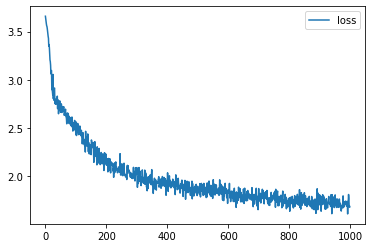

In [20]:
MAX_LENGTH = 50

for i in range(1000):
    batch_ix = to_matrix(sample_texts(20), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(
          predictions_logp.contiguous().view(-1, num_tokens), 
          actual_next_tokens.contiguous().view(-1))
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()

    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [22]:
generate_sample(char_rnn, seed_phrase=' my', max_length=50, temperature=0.8)

' my rad?\n                                         '

In [23]:
for i in range(10):
  print(generate_sample(char_rnn, seed_phrase=' ', max_length=50, temperature=0.5))

 buth the in the dese deast the on thou stor sun m
 the pand in with the fortere and the me weat thy 
 thee my mante the deat poth enger the shath the m
 the in the shours but the thin thet that so love,
 thy bere,
                                       
 the hell the that that sing and thy cave thee mor
 me sear me wite to that i sef thy stand make in l
 manter in thou freming shean,
                   
 fane thou dove suve thin mich and the in thou lic
 that your thy weart,
                            


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [27]:
lstm_model = LSMTModel(vocab_size=38, emb_size=16)

batch_ix = torch.tensor(to_matrix(sample_text_for_lstm(5)), dtype = torch.long)

logp_seq = lstm_loop(lstm_model, batch_ix)

predictions = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

loss = criterion(predictions.contiguous().view(-1, num_tokens), actual_next_tokens.contiguous().view(-1))
loss.backward()

In [28]:
lstm_model = LSMTModel(vocab_size=38, emb_size=16)
criterion = nn.NLLLoss()
lstm_opt = torch.optim.Adam(lstm_model.parameters())
lstm_history = []

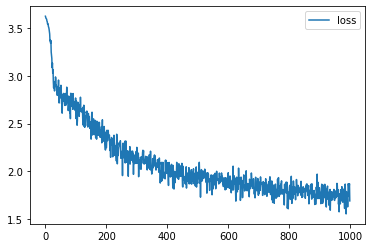

In [29]:
h_prev, c_prev = lstm_model.initial_state()

for i in range(1000):
    batch_ix = torch.tensor(to_matrix(sample_text_for_lstm(20, num_rows=2)), dtype = torch.long)
    
    logp_seq = lstm_loop(lstm_model, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(
          predictions_logp.contiguous().view(-1, num_tokens), 
          actual_next_tokens.contiguous().view(-1))
    
    # train with backprop
    loss.backward()
    lstm_opt.step()
    lstm_opt.zero_grad()

    
    lstm_history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(lstm_history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(lstm_history[:10]) > np.mean(lstm_history[-10:]), "RNN didn't converge."

Plot the loss function of the number of epochs. Does the final loss become better?

LSTM trains not so good. RNN showed much better results

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [36]:
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
  print('t = ', t)
  for _ in range(4):
    print(generate_sample_lstm(lstm_model, 'sometimes', temperature=t, max_length=50))
  print('--------------------------------')

t =  0.1
sometimes the the the seare the seare the seart th
sometimes the seare the the seart the seart the se
sometimes the seare the seare the seare the the se
sometimes the seare the seare the seare the seart 
--------------------------------
t =  0.2
sometimes the seare the the seart the core the the
sometimes the seare the seart the the be and the s
sometimes the seare the the the sure the seare the
sometimes the the the wing the shere the the the s
--------------------------------
t =  0.5
sometimes deet i ant o be thou the gion train the 
sometimess wothes of the the thor mave to love the
sometimes not of sull the seed and the me of love 
sometimes of the fart in saith the dill for preces
--------------------------------
t =  1.0
sometimes ouirt the hame imtherg you he ald be the
sometimes if or weet the brese:
,ouis wy wiv;
    
sometimeswurowe due not the teev ais her of gorena
sometimes forsesines not my theal, cowy madn i hou
--------------------------------
t =  2.0
sometim

Quality of LSTM predictiions seems to be  depends a lot on start phrase. Overall LSTM seems to be more connected. And big dependency on temperature is observed.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [38]:
lstm_path = 'lstm_model.t'
save_model(lstm_model, lstm_path)
lstm_loaded_model = load_model(LSMTModel, lstm_path)
generate_sample_lstm(lstm_loaded_model, ' ')

" ovfartl hezer'd,\nfirmin, i fa thy bakeett?\n      "

In [39]:
rnn_path = 'rnn_model.t'
save_model(char_rnn, rnn_path)
rnn_loaded_model = load_model(CharRNNCell, rnn_path)
generate_sample(rnn_loaded_model, ' ', temperature=0.2)

' the stath the sear the be the the my sor the the '

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)